# Download das imagens:


*   [bus.png](https://drive.google.com/file/d/1Z81FTJDeqsSfWkARj4Lfg5gdDNMs1nyl/view?usp=sharing)
*   [animal.png](https://drive.google.com/file/d/1azVtw40vpogTSv_7eaD8F32BSWSHTvjT/view?usp=sharing)
*   [ave.png](https://drive.google.com/file/d/1-_u8K0uGh_ZmDPog5JvwxRrfpxfouJlO/view?usp=sharing)
*   [carro.png](https://drive.google.com/file/d/1raleAAOvkcMA5LYSLoh-FLq8P-pPUdbf/view?usp=sharing)








# Itti & Koch
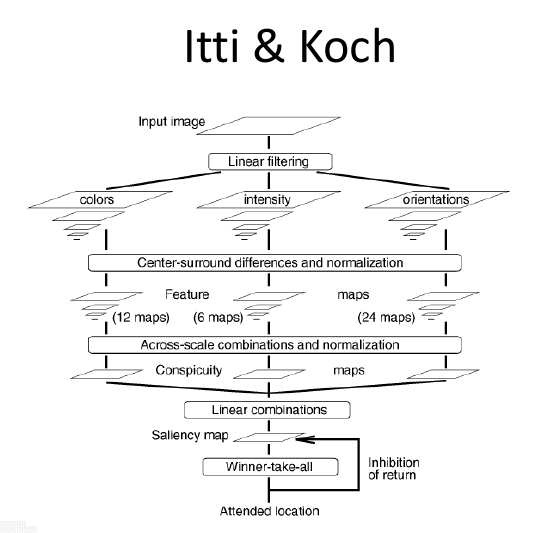

In [ ]:
!git clone https://github.com/akisatok/pySaliencyMap.git

Cloning into 'pySaliencyMap'...
remote: Enumerating objects: 54, done.
remote: Total 54 (delta 0), reused 0 (delta 0), pack-reused 54
Unpacking objects: 100% (54/54), done.


In [ ]:
%%writefile /content/pySaliencyMap/pySaliencyMap.py
#-------------------------------------------------------------------------------
# Name:        pySaliencyMap
# Purpose:     Extracting a saliency map from a single still image
#
# Author:      Akisato Kimura <akisato@ieee.org>
#
# Created:     April 24, 2014
# Copyright:   (c) Akisato Kimura 2014-
# Licence:     All rights reserved
#-------------------------------------------------------------------------------

import cv2
import numpy as np
import pySaliencyMapDefs

class pySaliencyMap:
    # initialization
    def __init__(self, width, height):
        self.width  = width
        self.height = height
        self.prev_frame = None
        self.SM = None
        self.GaborKernel0   = np.array(pySaliencyMapDefs.GaborKernel_0)
        self.GaborKernel45  = np.array(pySaliencyMapDefs.GaborKernel_45)
        self.GaborKernel90  = np.array(pySaliencyMapDefs.GaborKernel_90)
        self.GaborKernel135 = np.array(pySaliencyMapDefs.GaborKernel_135)

    # extracting color channels
    def SMExtractRGBI(self, inputImage):
        # convert scale of array elements
        src = np.float32(inputImage) * 1./255
        # split
        (B, G, R) = cv2.split(src)
        # extract an intensity image
        I = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
        # return
        return R, G, B, I

    # feature maps
    ## constructing a Gaussian pyramid
    def FMCreateGaussianPyr(self, src):
        dst = list()
        dst.append(src)
        for i in range(1,9):
            nowdst = cv2.pyrDown(dst[i-1])#borra a imagem e o faz o downsampling
            dst.append(nowdst)
        return dst
    ## taking center-surround differences
    def FMCenterSurroundDiff(self, GaussianMaps):
        dst = list()
        for s in range(2,5):
            now_size = GaussianMaps[s].shape
            now_size = (now_size[1], now_size[0])  ## (width, height)
            tmp = cv2.resize(GaussianMaps[s+3], now_size, interpolation=cv2.INTER_LINEAR)
            nowdst = cv2.absdiff(GaussianMaps[s], tmp)
            dst.append(nowdst)
            tmp = cv2.resize(GaussianMaps[s+4], now_size, interpolation=cv2.INTER_LINEAR)
            nowdst = cv2.absdiff(GaussianMaps[s], tmp)
            dst.append(nowdst)
        return dst
    ## constructing a Gaussian pyramid + taking center-surround differences
    def FMGaussianPyrCSD(self, src):
        GaussianMaps = self.FMCreateGaussianPyr(src)
        dst = self.FMCenterSurroundDiff(GaussianMaps)
        return dst
    ## intensity feature maps
    def IFMGetFM(self, I):
        return self.FMGaussianPyrCSD(I)
    ## color feature maps
    def CFMGetFM(self, R, G, B):
        # max(R,G,B)
        tmp1 = cv2.max(R, G)
        RGBMax = cv2.max(B, tmp1)
        RGBMax[RGBMax <= 0] = 0.0001    # prevent dividing by 0
        # min(R,G)
        RGMin = cv2.min(R, G)
        # RG = (R-G)/max(R,G,B)
        RG = (R - G) / RGBMax
        # BY = (B-min(R,G)/max(R,G,B)
        BY = (B - RGMin) / RGBMax
        # clamp nagative values to 0
        RG[RG < 0] = 0
        BY[BY < 0] = 0
        # obtain feature maps in the same way as intensity
        RGFM = self.FMGaussianPyrCSD(RG)
        BYFM = self.FMGaussianPyrCSD(BY)
        # return
        return RGFM, BYFM

    ## orientation feature maps
    def OFMGetFM(self, src):
        # creating a Gaussian pyramid
        GaussianI = self.FMCreateGaussianPyr(src)
        # convoluting a Gabor filter with an intensity image to extract orientation features
        GaborOutput0   = [ np.empty((1,1)), np.empty((1,1)) ]  # dummy data: any kinds of np.array()s are OK
        GaborOutput45  = [ np.empty((1,1)), np.empty((1,1)) ]
        GaborOutput90  = [ np.empty((1,1)), np.empty((1,1)) ]
        GaborOutput135 = [ np.empty((1,1)), np.empty((1,1)) ]
        for j in range(2,9):
            GaborOutput0.append(   cv2.filter2D(GaussianI[j], cv2.CV_32F, self.GaborKernel0) )
            GaborOutput45.append(  cv2.filter2D(GaussianI[j], cv2.CV_32F, self.GaborKernel45) )
            GaborOutput90.append(  cv2.filter2D(GaussianI[j], cv2.CV_32F, self.GaborKernel90) )
            GaborOutput135.append( cv2.filter2D(GaussianI[j], cv2.CV_32F, self.GaborKernel135) )
        # calculating center-surround differences for every oriantation
        CSD0   = self.FMCenterSurroundDiff(GaborOutput0)
        CSD45  = self.FMCenterSurroundDiff(GaborOutput45)
        CSD90  = self.FMCenterSurroundDiff(GaborOutput90)
        CSD135 = self.FMCenterSurroundDiff(GaborOutput135)
        # concatenate
        dst = list(CSD0)
        dst.extend(CSD45)
        dst.extend(CSD90)
        dst.extend(CSD135)
        # return
        return dst

    ## motion feature maps
    def MFMGetFM(self, src):
        # convert scale
        I8U = np.uint8(255 * src)
        cv2.waitKey(10)
        # calculating optical flows
        if self.prev_frame is not None:
            farne_pyr_scale= pySaliencyMapDefs.farne_pyr_scale
            farne_levels = pySaliencyMapDefs.farne_levels
            farne_winsize = pySaliencyMapDefs.farne_winsize
            farne_iterations = pySaliencyMapDefs.farne_iterations
            farne_poly_n = pySaliencyMapDefs.farne_poly_n
            farne_poly_sigma = pySaliencyMapDefs.farne_poly_sigma
            farne_flags = pySaliencyMapDefs.farne_flags
            flow = cv2.calcOpticalFlowFarneback(\
                prev = self.prev_frame, \
                next = I8U, \
                pyr_scale = farne_pyr_scale, \
                levels = farne_levels, \
                winsize = farne_winsize, \
                iterations = farne_iterations, \
                poly_n = farne_poly_n, \
                poly_sigma = farne_poly_sigma, \
                flags = farne_flags, \
                flow = None \
            )
            flowx = flow[...,0]
            flowy = flow[...,1]
        else:
            flowx = np.zeros(I8U.shape)
            flowy = np.zeros(I8U.shape)
        # create Gaussian pyramids
        dst_x = self.FMGaussianPyrCSD(flowx)
        dst_y = self.FMGaussianPyrCSD(flowy)
        # update the current frame
        self.prev_frame = np.uint8(I8U)
        # return
        return dst_x, dst_y

    # conspicuity maps
    ## standard range normalization
    def SMRangeNormalize(self, src):
        minn, maxx, dummy1, dummy2 = cv2.minMaxLoc(src)
        if maxx!=minn:
            dst = src/(maxx-minn) + minn/(minn-maxx)
        else:
            dst = src - minn
        return dst
    ## computing an average of local maxima
    def SMAvgLocalMax(self, src):
        # size
        stepsize = pySaliencyMapDefs.default_step_local
        width = src.shape[1]
        height = src.shape[0]
        # find local maxima
        numlocal = 0
        lmaxmean = 0
        for y in range(0, height-stepsize, stepsize):
            for x in range(0, width-stepsize, stepsize):
                localimg = src[y:y+stepsize, x:x+stepsize]
                lmin, lmax, dummy1, dummy2 = cv2.minMaxLoc(localimg)
                lmaxmean += lmax
                numlocal += 1
        # averaging over all the local regions
        return lmaxmean / (numlocal+1e-100)
    ## normalization specific for the saliency map model
    def SMNormalization(self, src):
        dst = self.SMRangeNormalize(src)
        lmaxmean = self.SMAvgLocalMax(dst)
        normcoeff = (1-lmaxmean)*(1-lmaxmean)
        return dst * normcoeff
    ## normalizing feature maps
    def normalizeFeatureMaps(self, FM):
        NFM = list()
        for i in range(0,6):
            normalizedImage = self.SMNormalization(FM[i])
            nownfm = cv2.resize(normalizedImage, (self.width, self.height), interpolation=cv2.INTER_LINEAR)
            NFM.append(nownfm)
        return NFM
    ## intensity conspicuity map
    def ICMGetCM(self, IFM):
        NIFM = self.normalizeFeatureMaps(IFM)
        ICM = sum(NIFM)
        return ICM
    ## color conspicuity map
    def CCMGetCM(self, CFM_RG, CFM_BY):
        # extracting a conspicuity map for every color opponent pair
        CCM_RG = self.ICMGetCM(CFM_RG)
        CCM_BY = self.ICMGetCM(CFM_BY)
        # merge
        CCM = CCM_RG + CCM_BY
        # return
        return CCM
    ## orientation conspicuity map
    def OCMGetCM(self, OFM):
        OCM = np.zeros((self.height, self.width))
        for i in range (0,4):
            # slicing
            nowofm = OFM[i*6:(i+1)*6]  # angle = i*45
            # extracting a conspicuity map for every angle
            NOFM = self.ICMGetCM(nowofm)
            # normalize
            NOFM2 = self.SMNormalization(NOFM)
            # accumulate
            OCM += NOFM2
        return OCM
    ## motion conspicuity map
    def MCMGetCM(self, MFM_X, MFM_Y):
        return self.CCMGetCM(MFM_X, MFM_Y)

    # core
    def SMGetSM(self, src):
        # definitions
        size = src.shape
        width  = size[1]
        height = size[0]
        # check
#        if(width != self.width or height != self.height):
#            sys.exit("size mismatch")
        # extracting individual color channels
        R, G, B, I = self.SMExtractRGBI(src)

        # extracting feature maps
        IFM = self.IFMGetFM(I)
        CFM_RG, CFM_BY = self.CFMGetFM(R, G, B)
        OFM = self.OFMGetFM(I)
        # MFM_X, MFM_Y = self.MFMGetFM(I) #motion features maps nas direções x,y

        # extracting conspicuity maps
        ICM = self.ICMGetCM(IFM)
        CCM = self.CCMGetCM(CFM_RG, CFM_BY)
        OCM = self.OCMGetCM(OFM)
        # MCM = self.MCMGetCM(MFM_X, MFM_Y)
        print('before:',np.asarray(CFM_RG).shape,np.asarray(IFM).shape,np.asarray(OFM).shape)
        print('after:',np.asarray(CCM).shape,np.asarray(ICM).shape,np.asarray(OCM).shape)

        # adding all the conspicuity maps to form a saliency map
        wi = pySaliencyMapDefs.weight_intensity
        wc = pySaliencyMapDefs.weight_color
        wo = pySaliencyMapDefs.weight_orientation
        # wm = pySaliencyMapDefs.weight_motion
        # SMMat = wi*ICM + wc*CCM + wo*OCM + wm*MCM
        SMMat = wi*ICM + wc*CCM + wo*OCM
        # normalize
        normalizedSM = self.SMRangeNormalize(SMMat)
        normalizedSM2 = normalizedSM.astype(np.float32)
        smoothedSM = cv2.bilateralFilter(normalizedSM2, 7, 3, 1.55)
        self.SM = cv2.resize(smoothedSM, (width,height), interpolation=cv2.INTER_NEAREST)
        # return
        return self.SM

    def SMGetBinarizedSM(self, src):
        # get a saliency map
        if self.SM is None:
            self.SM = self.SMGetSM(src)
        # convert scale
        SM_I8U = np.uint8(255 * self.SM)
        # binarize
        thresh, binarized_SM = cv2.threshold(SM_I8U, thresh=0, maxval=255, type=cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        return binarized_SM

    def SMGetSalientRegion(self, src):
        # get a binarized saliency map
        binarized_SM = self.SMGetBinarizedSM(src)
        # GrabCut
        img = src.copy()
        mask =  np.where((binarized_SM!=0), cv2.GC_PR_FGD, cv2.GC_PR_BGD).astype('uint8')
        bgdmodel = np.zeros((1,65),np.float64)
        fgdmodel = np.zeros((1,65),np.float64)
        rect = (0,0,1,1)  # dummy
        iterCount = 1
        cv2.grabCut(img, mask=mask, rect=rect, bgdModel=bgdmodel, fgdModel=fgdmodel, iterCount=iterCount, mode=cv2.GC_INIT_WITH_MASK)
        # post-processing
        mask_out = np.where((mask==cv2.GC_FGD) + (mask==cv2.GC_PR_FGD), 255, 0).astype('uint8')
        output = cv2.bitwise_and(img,img,mask=mask_out)
        return output


Overwriting /content/pySaliencyMap/pySaliencyMap.py


In [ ]:
%%writefile /content/pySaliencyMap/main.py

#-------------------------------------------------------------------------------
# Name:        main
# Purpose:     Testing the package pySaliencyMap
#
# Author:      Akisato Kimura <akisato@ieee.org>
#
# Created:     May 4, 2014
# Copyright:   (c) Akisato Kimura 2014-
# Licence:     All rights reserved
#-------------------------------------------------------------------------------

import cv2
import matplotlib.pyplot as plt
import pySaliencyMap
from google.colab.patches import cv2_imshow

lst_images = ['animal','ave','bus','carro']
index = 2
# main
if __name__ == '__main__':
    # read
    img = cv2.imread(lst_images[index]+'.png')
    
    # initialize
    imgsize = img.shape
    img_width  = imgsize[1]
    img_height = imgsize[0]

    sm = pySaliencyMap.pySaliencyMap(img_width, img_height)

    # computation
    saliency_map = sm.SMGetSM(img)
    # binarized_map = sm.SMGetBinarizedSM(img)
    # salient_region = sm.SMGetSalientRegion(img)
    cv2.imwrite(lst_images[index]+"_map.png", saliency_map*255)

#     # visualize
# #    plt.subplot(2,2,1), plt.imshow(img, 'gray')
#     plt.subplot(2,2,1), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     plt.title('Input image')
#     cv2_imshow(saliency_map)
#     
# #    cv2.imshow("input",  img)
#     plt.subplot(2,2,2), plt.imshow(saliency_map, 'gray')
#     plt.title('Saliency map')
# #    cv2.imshow("output", map)
#     plt.subplot(2,2,3), plt.imshow(binarized_map)
#     plt.title('Binarilized saliency map')
# #    cv2.imshow("Binarized", binarized_map)
#     plt.subplot(2,2,4), plt.imshow(cv2.cvtColor(salient_region, cv2.COLOR_BGR2RGB))
#     plt.title('Salient region')
# #    cv2.imshow("Segmented", segmented_map)

#     plt.show()
# #    cv2.waitKey(0)
#     cv2.destroyAllWindows()


Overwriting /content/pySaliencyMap/main.py


In [ ]:
!python /content/pySaliencyMap/main.py

/content/pySaliencyMap/pySaliencyMap.py:250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print('before:',np.asarray(CFM_RG).shape,np.asarray(IFM).shape,np.asarray(OFM).shape)
before: (6,) (6,) (24,)
after: (233, 297) (233, 297) (233, 297)


# FTSR

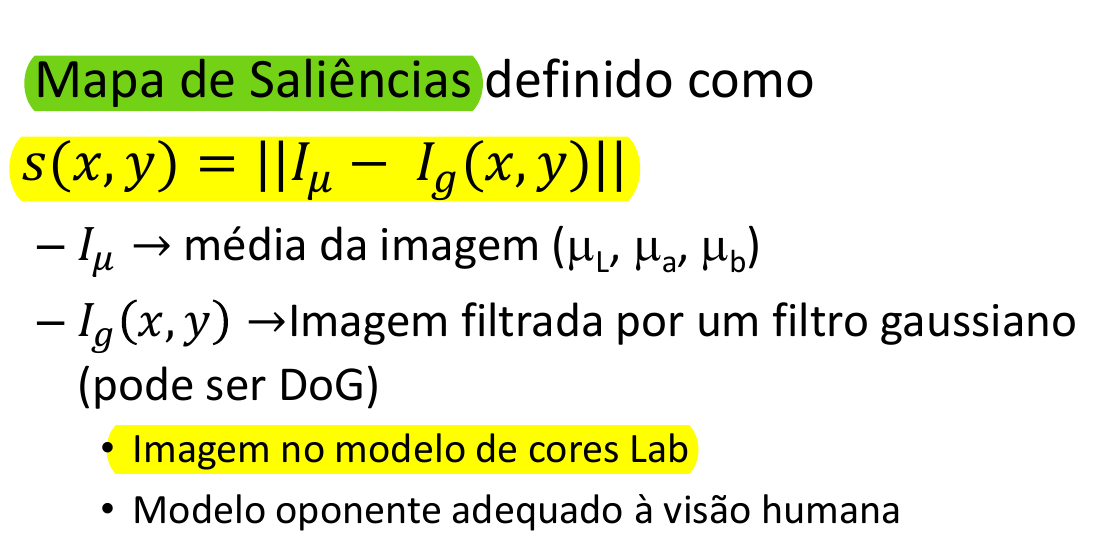

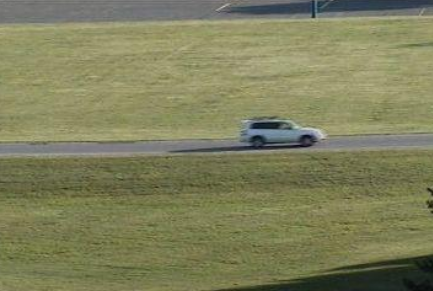

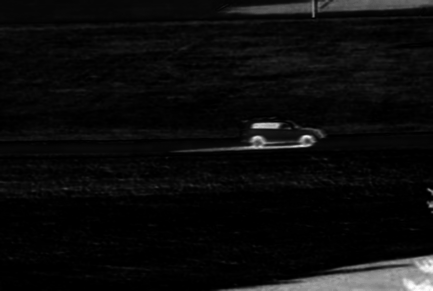

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow # for image display

# img = cv2.imread("bus.png")
# img = cv2.imread("animal.png")
# img = cv2.imread("ave.png")
img = cv2.imread("carro.png")

# Converte a imagem de entrada para lab
lab = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)

# Calula a média de cada matriz l, a, b
Im_l = lab[:, :,0].astype(np.float64);lm =  np.mean(Im_l)
Im_a = lab[:,:,1].astype(np.float64);am =  np.mean(Im_a)
Im_b = lab[:,:,2].astype(np.float64);bm =  np.mean(Im_b)


# Filtra a imagem de entrada com um filtro Gaussiano
gfrgb = cv2.GaussianBlur(img,(3,3),0)
lab2 = cv2.cvtColor(gfrgb,cv2.COLOR_BGR2LAB)

Ig_l = lab2[:, :,0].astype(np.float64)
Ig_a = lab2[:,:,1].astype(np.float64)
Ig_b = lab2[:,:,2].astype(np.float64)

# Mapa de saliência
sal_map = np.square(Ig_l-lm) +  np.square(Ig_a-am) +  np.square(Ig_b-bm)

# Normalizando o mapa
maximo = sal_map.max()
sal_map = sal_map/maximo

# print((sal_map*255).astype(np.uint8))
# cv2_imshow((sal_map*255).astype(np.uint8))
cv2_imshow(img)
cv2_imshow(sal_map*255)

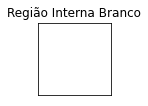

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow # for image display

matrix = np.array([ [1, 1, 1 ], 
                   [ 1, 1, 1 ], 
                   [ 1, 1, 1 ]  ],dtype=np.uint8)


# matrix = np.ones((200,200,1),dtype=np.uint8)
plt.subplot(143),plt.imshow(matrix, cmap ='gray',vmin=0, vmax=1),plt.title('Região Interna Branco')
plt.xticks([]), plt.yticks([])
cv2_imshow(matrix)
# vmin=0, vmax=255